<h1>Image Processing</h1>

Functions for horizontal reflection of images and segmenting the image similar to the method described in MM-DFR: http://arxiv.org/pdf/1509.00244v1.pdf. Image down sampling and random gaussian noise.

In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

import os
import dlib
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import sys

from IPython.display import Image as Display
from matplotlib.pyplot import imshow 
from scipy.spatial import distance
from scipy.ndimage.filters import gaussian_filter

from skimage import io
from skimage.color import rgb2grey
from skimage.transform import resize
from skimage.util.shape import view_as_windows

from PIL import Image

In [3]:
data_cropped_path = '../../data/lfw_cropped'
data_path = '../../data'
width, height = 230, 230

In [4]:
def get_face_to_file_path_dict():
    face_to_file_paths_dict = {}
    
    for root, dirnames, filenames in os.walk(data_cropped_path):
        for dirname in dirnames:
            if dirname not in face_to_file_paths_dict:
                face_to_file_paths_dict[dirname] = []
            directory_path = os.path.join(data_cropped_path, dirname)
            for filename in os.listdir(directory_path):
                if filename.endswith(".jpg"):
                    face_to_file_paths_dict[dirname].append(os.path.join(directory_path, filename))
                            
    return face_to_file_paths_dict

In [5]:
def reflection(image):
    return np.array([list(reversed(row)) for row in image])

In [6]:
def partition(image, top_left, rows, cols):
    return np.array([row[top_left[1]:top_left[1] + cols] for row in image[top_left[0]:top_left[0] + rows]])

In [7]:
face_to_file_paths = get_face_to_file_path_dict()

In [8]:
image = io.imread(face_to_file_paths.items()[5][1][0])

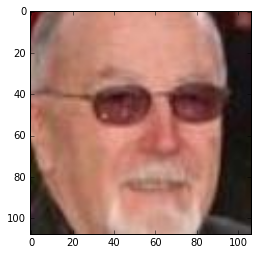

In [9]:
imshow(image)

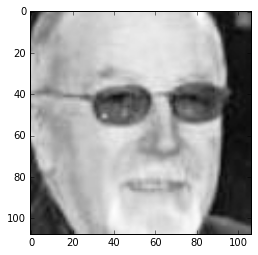

In [38]:
grey_image = rgb2grey(image)
imshow(grey_image, cmap='Greys_r')

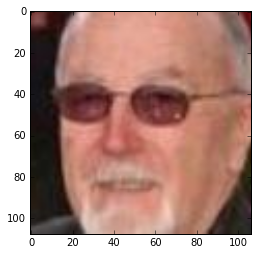

In [36]:
reflected_image = reflection(image)
imshow(reflected_image, cmap='Greys_r')

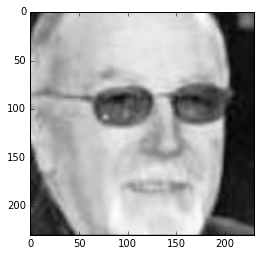

In [39]:
resized_image = resize(grey_image, (width, height))
imshow(resized_image, cmap='Greys_r')

<h2>Partitioning/Windowing</h2>

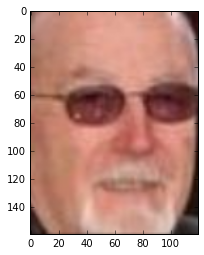

In [13]:
imshow(partition(resized_image, (0, 20), 160, 120))

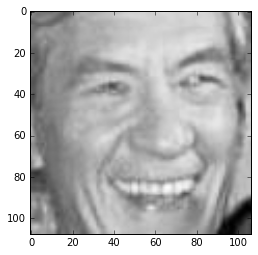

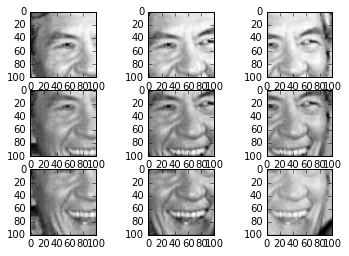

In [40]:
window_size = 100, 100
grey_image = rgb2grey(io.imread(face_to_file_paths.items()[1130][1][0]))
imshow(grey_image, cmap='Greys_r')
windows = view_as_windows(resize(grey_image, (150, 150)), window_size, 25)
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(windows[i, j], cmap='Greys_r')

<h2>Image Jittering</h2>

Random Gaussian noise on coordinates of the five facial feature point. Noise distributed with zero mean and standard deviation of four pixels.

https://matthewearl.github.io/2015/07/28/switching-eds-with-python/


In [14]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(os.path.join(data_path, 'shape_predictor_68_face_landmarks.dat'))

In [15]:
def get_centroid(points):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    return (sum(x) / len(points), sum(y) / len(points))
    
def get_facial_feature_points(im):
    img = im
    if(len(im.shape)<3):
        img = (im * 255).astype(np.uint8)

    rects = detector(img, 1)

    if len(rects) > 1:
        raise 'Too Many Faces'
    if len(rects) == 0:
        raise 'No Faces'
            
    points = np.array([[p.x, p.y] for p in predictor(img, rects[0]).parts()])

    facial_feature_points = [None for i in range(5)]
    
    # Left and right eyes, nose, left and right points of the mouth
    facial_feature_points[0] = get_centroid(np.concatenate((points[37:39], points[40:42])))
    facial_feature_points[1] = get_centroid(np.concatenate((points[43:45], points[46:48])))
    facial_feature_points[2] = points[30]
    facial_feature_points[3] = points[48]
    facial_feature_points[4] = points[54]
    
    return np.array(facial_feature_points)

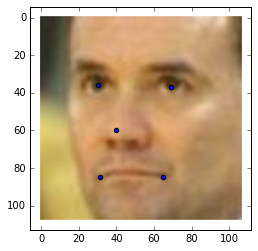

In [16]:
image = io.imread(face_to_file_paths.items()[90][1][0])
imshow(image)
coords = np.transpose(get_facial_feature_points(image))
plt.scatter(coords[0], coords[1])
plt.show()

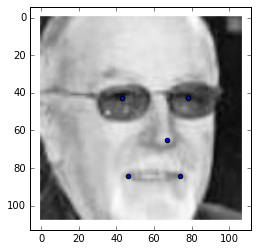

In [17]:
coords = np.transpose(get_facial_feature_points(grey_image))
imshow(grey_image, cmap='Greys_r')
plt.scatter(coords[0], coords[1])
plt.show()

In [31]:
def get_random_noise_image(image, coords, width):
    """
    Apply random gaussian generated values
    and distribute them on gaussian distributed square
    centered on the coordinates passed in for the image
    """
    
    noise = np.zeros((image.shape[0], image.shape[1]))
    for coord in coords:
        apply_noise_at_point(coord[1], coord[0], noise, width)
    return np.clip(image + noise, 0, 1)

def apply_noise_at_point(x, y, noise, width):
    """
    Generate a block with a single random value placed at the center
    Apply the Gaussian filter with std of 4
    Place it on the noise array at the appropriate coordinates
    """
    
    block = np.zeros((width, width))
    block[width / 2, width / 2] = np.random.normal()
    block = gaussian_filter(block, sigma=4)

    x -= width / 2
    y -= width / 2
    
    x_end = min(noise.shape[0] - x, block.shape[0])
    x_start =  max(0, -x)

    y_end = min(noise.shape[1] - y, block.shape[1])
    y_start = max(0, -y)

    noise[max(0, x):x+block.shape[0], max(0, y):y+block.shape[1]] = block[x_start:x_end,y_start:y_end]

In [32]:
coords = get_facial_feature_points(grey_image)

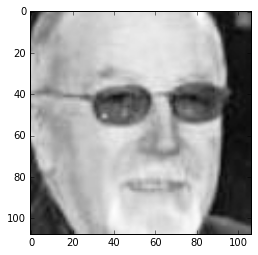

In [45]:
imshow(get_random_noise_image(grey_image, coords, 9), cmap='Greys_r')

In [46]:
(get_random_noise_image(grey_image, coords, 9) - grey_image != 0).sum()

405

In [24]:
get_random_noise_image(np.zeros((10, 10)), [[3, 3], [7, 7]], 3)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.0092949 ,  0.00929505,  0.0092949 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00929505,  0.0092952 ,  0.00929505,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.0092949 ,  0.00929505,  0.0092949 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.14707466,  0.14707704